# Evaluate Theme Clasification and Summarization

1. **Theme classification**: Precision, Recall and F1 Score 
2. **Entity based sentiment**: Accuracy of Brand identification and Precision, Recall and F1 Score Sentiment 
3. **Automated Headlines evaluation**: (*Note: The generated Headlines need to be in English irrespective of the language in the article*)
Average similarity scores of AI generated headlines compared with actual headlines would be used as a metric for evaluation.
4. **Rough and BLEU score**: To evaluate the language summarization.

### Folder Structure 

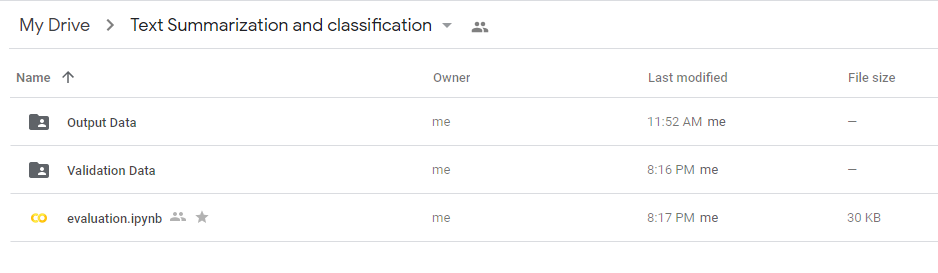

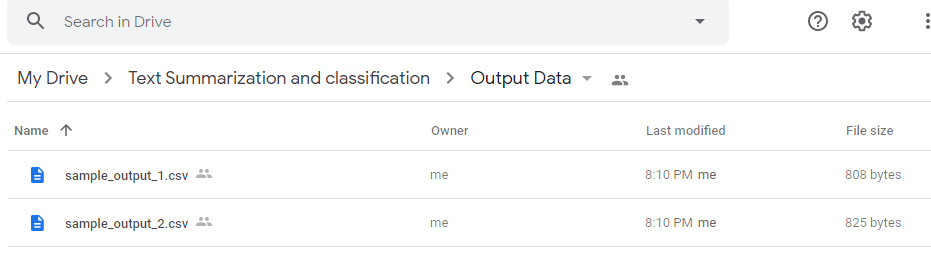

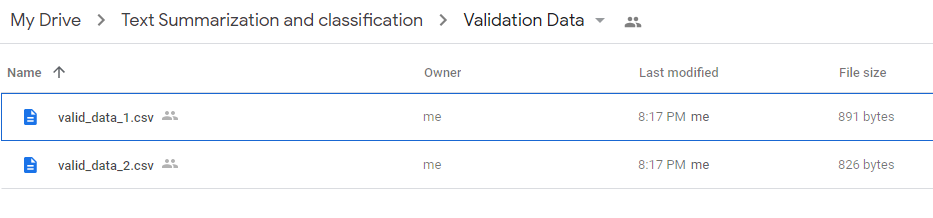

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Create your working directory

In [2]:
import os 

# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "Text Summarization and classification/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    os.mkdir(root_dir + project_folder + "/Output Data")
    os.mkdir(root_dir + project_folder + "/Valid Output")
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  #!touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder)

create_and_set_working_directory(project_folder)


Your working directory was changed to /content/drive/My Drive/Text Summarization and classification/


In [3]:
!pip install -U sentence-transformers
!pip install -U rouge
!pip install fuzzywuzzy

     |████████████████████████████████| 71kB 3.2MB/s 
     |████████████████████████████████| 1.9MB 7.6MB/s 
     |████████████████████████████████| 1.2MB 35.3MB/s 
     |████████████████████████████████| 890kB 51.0MB/s 
     |████████████████████████████████| 3.2MB 51.3MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.4.1.2-cp37-none-any.whl size=103068 sha256=602382d3fbccd94364b9664663d134a6188925718e9c604e04c2289a1fc6472b
  Stored in directory: /root/.cache/pip/wheels/3d/33/d1/5703dd56199c09d4a1b41e0c07fb4e7765a84d787cbdc48ac3
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=0a18acba51a96c7b2d9dd69cb1143faae489f4d2e2ffa9667041e78c30d7edd8
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [4]:
# Import libraries
import scipy
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from rouge import Rouge
from statistics import mean
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from fuzzywuzzy import fuzz
import nltk
nltk.download('punkt')
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Read Data


*   Output files should be placed in "Output Data" folder



In [5]:
# Reading the output data
out1_df = pd.read_csv("Output Data/sample_output_1.csv")
out2_df = pd.read_csv("Output Data/sample_output_2.csv")

# read validation data
valid_output1_df = pd.read_csv("Validation Data/valid_data_1.csv")
valid_output2_df = pd.read_csv("Validation Data/valid_data_2.csv")

valid_output1_df = valid_output1_df[['Text_ID', 'Mobile_Tech_Flag_Actual', 'Headline_Actual_Eng']]
valid_output2_df = valid_output2_df[['Text_ID', 'Mobile_Tech_Flag_Actual', 'Brands_Entity_Actual', 'Sentiment_Actual']]

In [6]:
output1_df = valid_output1_df.merge(out1_df, on = 'Text_ID', how='outer')
output2_df = valid_output2_df.merge(out2_df, on = 'Text_ID', how='outer')

In [7]:
output1_df['Headline_Actual_Eng'] = output1_df['Headline_Actual_Eng'].str.lower()
output1_df['Headline_Generated_Eng_Lang'] = output1_df['Headline_Generated_Eng_Lang'].str.lower()
output2_df['Brands_Entity_Actual'] = output2_df['Brands_Entity_Actual'].str.lower()
output2_df['Sentiment_Actual'] = output2_df['Sentiment_Actual'].str.lower()
output2_df['Brands_Entity_Identified'] = output2_df['Brands_Entity_Identified'].str.lower()
output2_df['Sentiment_Identified'] = output2_df['Sentiment_Identified'].str.lower()

In [8]:
# Data subsetting

# Articles
count_article_df = output1_df[output1_df['Text_ID'].astype(str).str.contains('article', case=False, regex=True)]
df1 = count_article_df['Mobile_Tech_Flag_Actual'].value_counts()
article_mobile_tech, article_others = df1[1], df1[0]

# Tweets
count_tweet_df = output1_df[output1_df['Text_ID'].astype(str).str.contains('tweet', case=False, regex=True)]
df2 = count_tweet_df['Mobile_Tech_Flag_Actual'].value_counts()
tweet_mobile_tech, tweet_others = df2[1], df2[0]

# Articles and Tweets with mobile tech
mobile_tech_count_df = pd.DataFrame(columns=['Mobile_Tech', 'Others'])
mobile_tech_count_df.loc['Articles',:] = [article_mobile_tech,article_others]
mobile_tech_count_df.loc['Tweets',:] = [tweet_mobile_tech,tweet_others]

## Theme Classification Metrices

In [9]:
# Overall
# Theme classification Actual and Predicted labels
y_mobiletech_true = output1_df['Mobile_Tech_Flag_Actual'].values
y_mobiletech_pred = output1_df['Mobile_Tech_Flag_Predicted'].values

# Get scores for Theme classification
precision = round(precision_score(y_mobiletech_true, y_mobiletech_pred),2)
recall = round(recall_score(y_mobiletech_true, y_mobiletech_pred),2)
f_score = round(f1_score(y_mobiletech_true, y_mobiletech_pred),2)
acc_score = round(accuracy_score(y_mobiletech_true, y_mobiletech_pred),2)

# Article
# Theme classification Actual and Predicted labels
article1_df = output1_df[output1_df['Text_ID'].astype(str).str.contains('article', case=False, regex=True)]
article1_mobiletech_true = article1_df['Mobile_Tech_Flag_Actual'].values
article1_mobiletech_pred = article1_df['Mobile_Tech_Flag_Predicted'].values

# Get scores for Theme classification
article_precision = round(precision_score(article1_mobiletech_true, article1_mobiletech_pred),2)
article_recall = round(recall_score(article1_mobiletech_true, article1_mobiletech_pred),2)
article_f_score = round(f1_score(article1_mobiletech_true, article1_mobiletech_pred),2)
article_acc_score = round(accuracy_score(article1_mobiletech_true, article1_mobiletech_pred),2)

# Tweets
# Theme classification Actual and Predicted labels
tweet1_df = output1_df[output1_df['Text_ID'].astype(str).str.contains('tweet', case=False, regex=True)]
tweet_mobiletech_true = tweet1_df['Mobile_Tech_Flag_Actual'].values
tweet_mobiletech_pred = tweet1_df['Mobile_Tech_Flag_Predicted'].values

# Get scores for Theme classification
tweet_precision = round(precision_score(tweet_mobiletech_true, tweet_mobiletech_pred),2)
tweet_recall = round(recall_score(tweet_mobiletech_true, tweet_mobiletech_pred),2)
tweet_f_score = round(f1_score(tweet_mobiletech_true, tweet_mobiletech_pred),2)
tweet_acc_score = round(accuracy_score(tweet_mobiletech_true, tweet_mobiletech_pred),2)

## Calculate Headline Similarity
  - Actual Headline
  - Generated Headline in Original Language

In [10]:
# Headlines Actual and Predicted
headline_df = output1_df[~output1_df['Headline_Actual_Eng'].isna()]
headline_df["Headline_Generated_Eng_Lang"].fillna("", inplace = True)
y_headlines_true = headline_df['Headline_Actual_Eng']
y_headlines_pred = headline_df['Headline_Generated_Eng_Lang']

# Get average document similarity using BERT
model = SentenceTransformer('bert-base-nli-mean-tokens')

headline_similarity = []
for actual_headline, predicted_headline in zip(y_headlines_true, y_headlines_pred):
  actual_headline_embeddings = model.encode(actual_headline) # Get a vector for each headlines
  predicted_headline_embeddings = model.encode(predicted_headline) # Get a vector for each headlines
  distance = scipy.spatial.distance.cdist([actual_headline_embeddings], [predicted_headline_embeddings], "cosine")[0]
  headline_similarity.append("%.4f" % (1-distance))

headline_similarity = list(map(float, headline_similarity))
avg_headline_sim_score = round(mean(headline_similarity),2)

100%|██████████| 405M/405M [05:53<00:00, 1.14MB/s]


## Calculate Rouge Scores for text summarization

In [11]:
rouge = Rouge()

# Headlines Actual and Predicted
headline_df = output1_df[~output1_df['Headline_Actual_Eng'].isna()]
headline_df["Headline_Generated_Eng_Lang"].fillna("No Headline", inplace = True)

y_headlines_true = headline_df['Headline_Actual_Eng']
y_headlines_pred = headline_df['Headline_Generated_Eng_Lang']

rouge_scores = []
for actual_headline, predicted_headline in zip(y_headlines_true, y_headlines_pred):
  if predicted_headline=="":
    rouge_scores.append({'f': 0,'p': 0,'r': 0})
  else:
    #print(actual_headline)
    #print(predicted_headline)
    rouge_score = rouge.get_scores(actual_headline, predicted_headline)
    rouge_scores.append(rouge_score[0]['rouge-l'])

# Averaging the scores
f = [score['f'] for score in rouge_scores]
p = [score['p'] for score in rouge_scores]
r = [score['r'] for score in rouge_scores]

avg_rogue_scores = {'F1 Score':round(mean(f),2),
                    'Precision':round(mean(p),2),
                    'Recall':round(mean(r),2)}

## Calculate BLEU Scores for text summarization

In [12]:
headline_df = output1_df[~output1_df['Headline_Actual_Eng'].isna()]
headline_df["Headline_Generated_Eng_Lang"].fillna("", inplace = True)
org_headlines = headline_df['Headline_Actual_Eng'] # summarized texts
gen_headlines = headline_df['Headline_Generated_Eng_Lang'] # summarized texts

bleu_scores = []
for org_headline, gen_headline in zip(org_headlines, gen_headlines):
  if gen_headline=="":
    bleu_scores.append(0)
  else:
    hypothesis = gen_headline.split()
    reference = org_headline.split()
    references = [reference] # list of references for 1 sentence.
    list_of_references = [references] # list of references for all sentences in corpus.
    list_of_hypotheses = [hypothesis] # list of hypotheses that corresponds to list of references.
    bleu_score = corpus_bleu(list_of_references, list_of_hypotheses)
    bleu_scores.append(bleu_score)

avg_bleu_scores = round(mean(bleu_scores),2)

## Evaluate Sentiment Analysis

# Brand Similarity and Sentiment Score Evaluation

In [13]:
# fuzzy matching for Brands
sentiment_df = output2_df[~(output2_df['Brands_Entity_Actual'].isna() & output2_df['Brands_Entity_Identified'].isna())]

def compute_sim(text, my_list, threshold):
  #score_list = [(fuzz.ratio(text, x), x) for x in my_list]
  if len(my_list)>0:
    score_list = [(1, x) for x in my_list if fuzz.ratio(text, x)>threshold]
  else:
    score_list = []
  if score_list:
    return 1, str(score_list[0][1])
  else:
    return 0, ""

final_df = pd.DataFrame()
for id in sentiment_df['Text_ID'].unique():
  temp_df = output2_df.loc[output2_df['Text_ID'] == id, ].reset_index(drop=True)

  actual_list, predict_list = list(temp_df['Brands_Entity_Actual'].unique()), list(temp_df['Brands_Entity_Identified'].unique())

  temp_df_actual = temp_df[['Text_ID','Brands_Entity_Actual','Sentiment_Actual']].drop_duplicates()
  temp_df_predict = temp_df[['Text_ID','Brands_Entity_Identified','Sentiment_Identified']].drop_duplicates(subset=['Text_ID','Brands_Entity_Identified'])

  temp_df_actual = temp_df_actual.reset_index(drop=True)
  temp_df_predict = temp_df_predict.reset_index(drop=True)

  temp_df_actual['Actual_Brand'], temp_df_predict['Prediction_Brand'] = 0,0
  temp_df_actual['Actual_Sent'], temp_df_predict['Prediction_Sent'] = 0,0

  for i in range(temp_df_actual.shape[0]):
    temp_df_actual.loc[i,'Actual_Brand'], match_text = compute_sim(temp_df_actual.loc[i, 'Brands_Entity_Actual'], my_list=predict_list, threshold=75)
    if temp_df_actual.loc[i,'Actual_Brand'] == 1:
      df_A = temp_df_predict.loc[temp_df_predict['Brands_Entity_Identified'] == match_text,'Sentiment_Identified'].reset_index(drop=True)
      temp_df_actual.loc[i,'Actual_Sent'] = bool(temp_df_actual.loc[i,'Sentiment_Actual'] == df_A[0])

  for i in range(temp_df_predict.shape[0]):
    temp_df_predict.loc[i,'Prediction_Brand'], match_text = compute_sim(str(temp_df_predict.loc[i, 'Brands_Entity_Identified']), actual_list, threshold=75)
    if temp_df_predict.loc[i,'Prediction_Brand'] == 1:
      df_B = temp_df_actual.loc[temp_df_actual['Brands_Entity_Actual'] == match_text,'Sentiment_Actual'].reset_index(drop=True)
      temp_df_predict.loc[i,'Prediction_Sent'] = bool(temp_df_predict.loc[i,'Sentiment_Identified'] == df_B[0])

  temp_df1 = pd.DataFrame({'Text_ID': id,
                           'Recall_Brand': round(temp_df_actual['Actual_Brand'].sum()/(len(temp_df_actual)),2),
                           'Precision_Brand': round(temp_df_predict['Prediction_Brand'].sum()/len(temp_df_predict),2),
                           'Recall_Sent': round(temp_df_actual['Actual_Sent'].sum()/(len(temp_df_actual)),2),
                           'Precision_Sent': round(temp_df_predict['Prediction_Sent'].sum()/len(temp_df_predict),2)}, index=[0])

  final_df = final_df.append(temp_df1)

In [14]:
# Text Sentiment Scores
# Overall
overall_sent_precision = round(final_df['Precision_Sent'].mean(),2)
overall_sent_recall = round(final_df['Recall_Sent'].mean(),2)

# article
article2_df = final_df[final_df['Text_ID'].astype(str).str.contains('article', case=False, regex=True)]
article_sent_precision = round(article2_df['Precision_Sent'].mean(),2)
article_sent_recall = round(article2_df['Recall_Sent'].mean(),2)

# tweets
tweet2_df = final_df[final_df['Text_ID'].astype(str).str.contains('tweet', case=False, regex=True)]
tweet_sent_precision = round(tweet2_df['Precision_Sent'].mean(),2)
tweet_sent_recall = round(tweet2_df['Recall_Sent'].mean(),2)

# Brand Prediction Scores
# Overall
overall_brand_precision = round(final_df['Precision_Brand'].mean(),2)
overall_brand_recall = round(final_df['Recall_Brand'].mean(),2)

# article
article2_df = final_df[final_df['Text_ID'].astype(str).str.contains('article', case=False, regex=True)]
article_brand_precision = round(article2_df['Precision_Brand'].mean(),2)
article_brand_recall = round(article2_df['Recall_Brand'].mean(),2)

# tweets
tweet2_df = final_df[final_df['Text_ID'].astype(str).str.contains('tweet', case=False, regex=True)]
tweet_brand_precision = round(tweet2_df['Precision_Brand'].mean(),2)
tweet_brand_recall = round(tweet2_df['Recall_Brand'].mean(),2)

## Generate Evaluation Report

In [15]:
print("**  Data Overview **")
print(mobile_tech_count_df)

print("="*30, "Article", "="*30)
print("1. Theme classification evaluation (for mobile tech):")
print('> Precision : {}%'.format(round(article_precision*100,2)))
print(f'> Recall : {article_recall*100}%')
print(f'> F1 Score: {article_f_score*100}%')
print(f'> Accuracy Score: {acc_score*100}%')
print('-'*5)
print("2. Entity based evaluation")
print("Brand Identification:")
print(f'> Precision : {article_brand_precision*100}%')
print(f'> Recall : {article_brand_recall*100}%')
print('-'*5)
print("Sentiment Analysis:")
print(f'> Precision : {article_sent_precision*100}%')
print(f'> Recall : {article_sent_recall*100}%')
print('-'*5)
print('3. Automated Headlines evaluation')
print(f'--> Average similarity scores: {avg_headline_sim_score*100}%')
print("--> Rough Score:")
for k,v in avg_rogue_scores.items():
  print('\t> {} : {}%'.format(k, round(v*100,2)))
print(f'--> BLEU Score: {avg_bleu_scores*100}%')
print('-'*70)
#----------------------------------------------------------------
print("="*30, "Tweet", "="*30)
print("1. Theme classification evaluation (for mobile tech):")
print(f'> Precision : {tweet_precision*100}%')
print(f'> Recall : {tweet_recall*100}%')
print(f'> F1 Score: {tweet_f_score*100}%')
print('-'*5)
print("2. Entity based evaluation")
print("Brand Identification:")
print(f'> Precision : {tweet_brand_precision*100}%')
print(f'> Recall : {tweet_brand_recall*100}%')
print('-'*5)
print("Sentiment Analysis:")
print(f'> Precision : {tweet_sent_precision*100}%')
print(f'> Recall : {tweet_sent_recall*100}%')
print('-'*70)
#----------------------------------------------------------------
print("="*30, "Overall", "="*30)
print("1. Theme classification evaluation (for mobile tech):")
print(f'> Precision : {precision*100}%')
print(f'> Recall : {recall*100}%')
print(f'> F1 Score: {f_score*100}%')
print(f'> Accuracy Score: {acc_score*100}%')
print('-'*5)
print("2. Entity based evaluation")
print("Brand Identification:")
print(f'> Precision : {overall_brand_precision*100}%')
print(f'> Recall : {overall_brand_recall*100}%')
print('-'*5)
print("Sentiment Analysis:")
print(f'> Precision : {overall_sent_precision*100}%')
print(f'> Recall : {overall_sent_recall*100}%')
print('3. Automated Headlines evaluation')
print(f'--> Average similarity scores: {avg_headline_sim_score*100}%')
print("--> Rough Score:")
for k,v in avg_rogue_scores.items():
  print('\t> {} : {}%'.format(k, round(v*100,2)))  
print(f'--> BLEU Score : {avg_bleu_scores*100}%')
print('-'*70)

**  Data Overview **
         Mobile_Tech Others
Articles           7      8
Tweets             8      7
============================== Article ==============================
1. Theme classification evaluation (for mobile tech):
> Precision : 100.0%
> Recall : 86.0%
> F1 Score: 92.0%
> Accuracy Score: 93.0%
-----
2. Entity based evaluation
Brand Identification:
> Precision : 22.0%
> Recall : 22.0%
-----
Sentiment Analysis:
> Precision : 22.0%
> Recall : 22.0%
-----
3. Automated Headlines evaluation
--> Average similarity scores: 82.0%
--> Rough Score:
	> F1 Score : 68.0%
	> Precision : 61.0%
	> Recall : 76.0%
--> BLEU Score: 48.0%
----------------------------------------------------------------------
============================== Tweet ==============================
1. Theme classification evaluation (for mobile tech):
> Precision : 89.0%
> Recall : 100.0%
> F1 Score: 94.0%
-----
2. Entity based evaluation
Brand Identification:
> Precision : 30.0%
> Recall : 30.0%
-----
Sentiment Anal